In [1]:
import crepe
import numpy as np
import os
import glob
from scipy.io import wavfile

root_dir = "./amicorpus/*/audio/"
ami_corpus = glob.glob(os.path.join(root_dir, '*wav'))
        

In [ ]:
for file in ami_corpus:
    try:
        sr, audio = wavfile.read(file)
        filename = (file.split("/")[-1]).split(".")[0]
        print (filename)
        time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True, step_size=100)
        np.save("./crepe_ami_storage/" + filename + "Mix-Headset_freq", frequency)
        np.save("./crepe_ami_storage/" + filename + "Mix-Headset_conf", confidence)

    except:
        print ("pass")
        pass


In [ ]:
sr, audio = wavfile.read("TV_bubi6_2017-04-11_gek.wav")
time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)

In [ ]:
sr

In [42]:
confidence = np.load("./crepe_ami_storage/EN2001aMix-Headset_conf.npy")
frequency = np.load("./crepe_ami_storage/EN2001aMix-Headset_freq.npy")

In [10]:
filename = "EN2001a.Mix-Headset"

In [11]:
from pyannote.database import get_protocol
protocol = get_protocol('AMI.SpeakerDiarization.MixHeadset')

for i in protocol.train():
    if (i["uri"] == filename):
         reference = i['annotation']

for i in protocol.test():
    if (i["uri"] == filename):             
        reference = i['annotation']

for i in protocol.development():
    if (i["uri"] == filename):             
        reference = i['annotation']


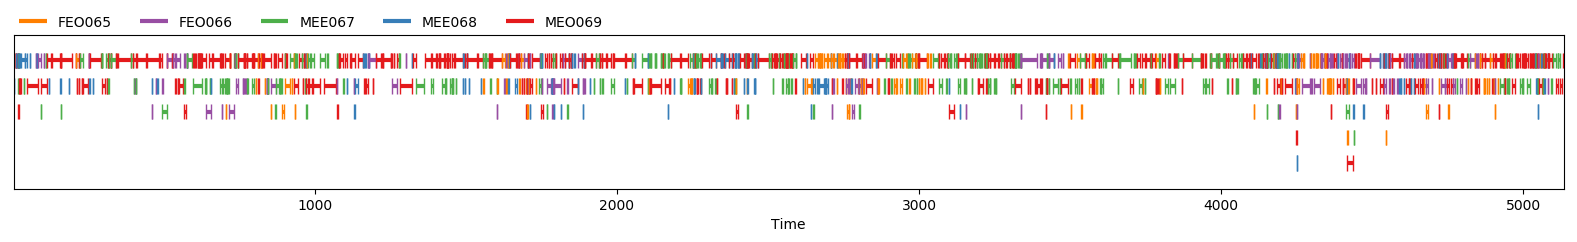

In [14]:
reference

In [60]:
import matplotlib.pyplot as pp
%matplotlib inline
pp.rcParams['figure.figsize'] = (30, 3.0)


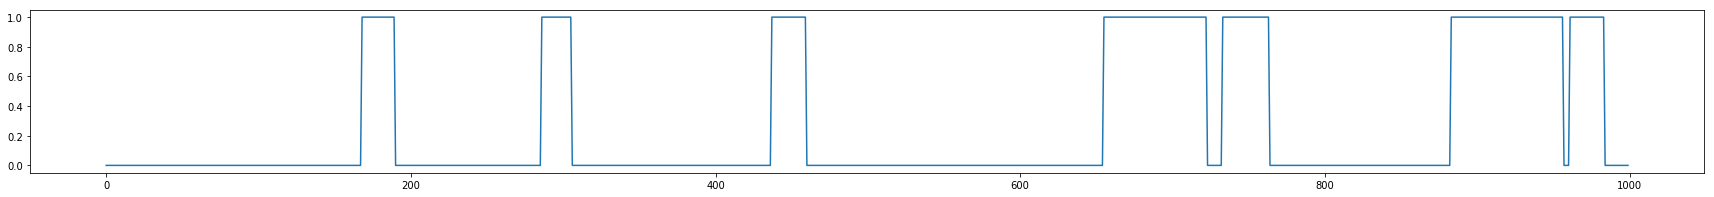

In [125]:
pp.plot(create_prediction(confidence[0:1000], 20, 0.6))

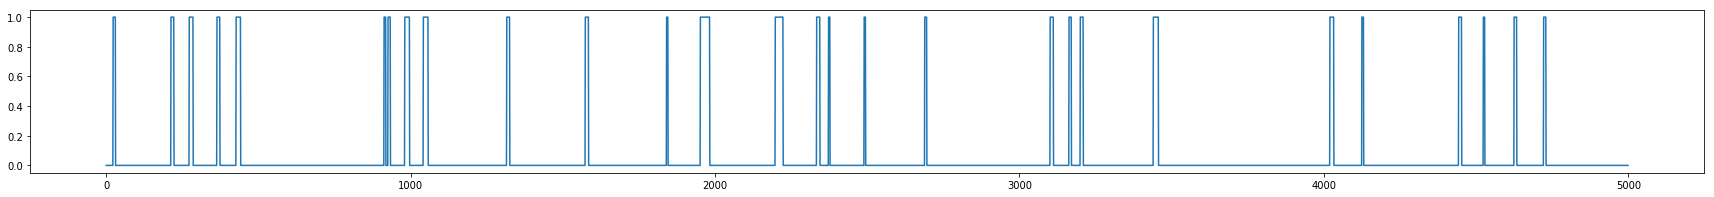

In [141]:
pp.plot(create_prediction_freq(frequency[0:5000], 10, 25))

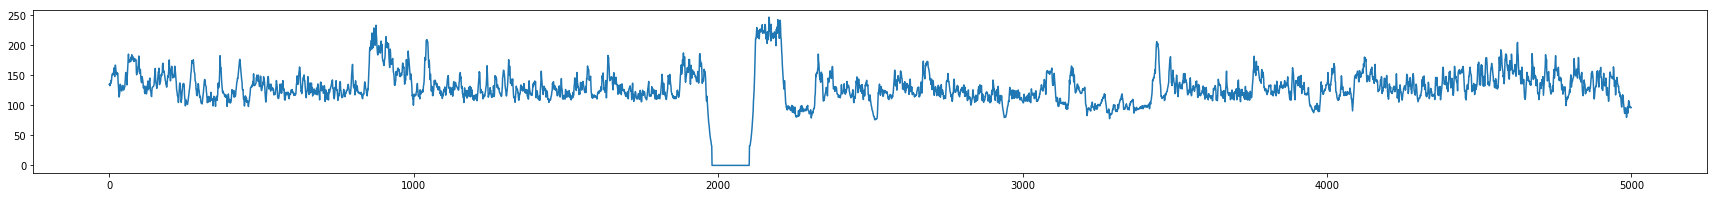

In [145]:
pp.plot(frequency[0:5000])

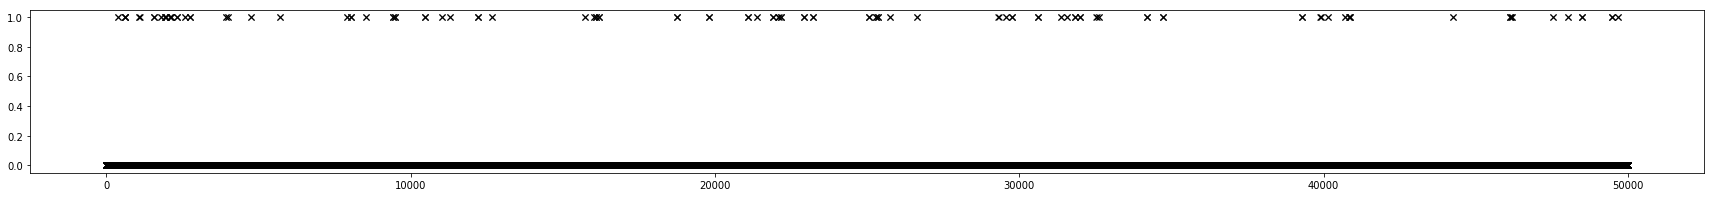

In [142]:
import math
ground_truth = txt_file_to_matrix(filename, "reference", 16000, "featureplan_new.txt", hop=10, win_len=25, feature_extractor="yaafe")
pp.plot(ground_truth[0:50000], 'x', color='black');

In [112]:
len(ground_truth)

525025

In [113]:
len(frequency)

52503

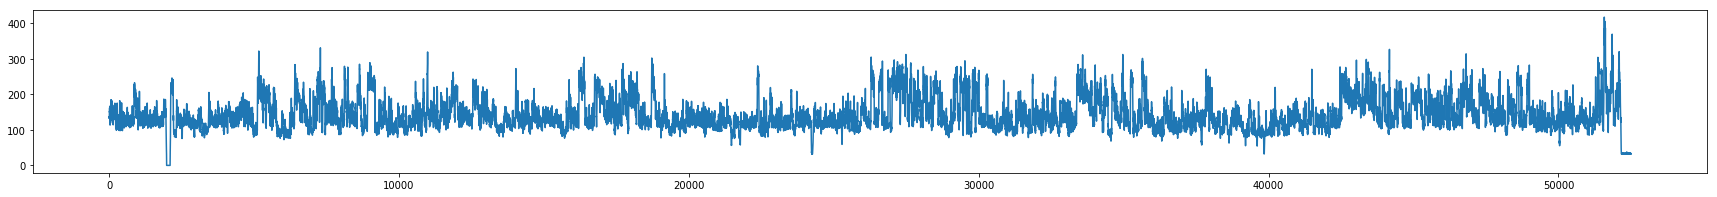

In [111]:
pp.plot(frequency)

In [15]:
# use directly frequency and confidence matrix without Deep Learning

def create_prediction(confidence, step, threshold):
    length_of_matrix = len(confidence)
    
    prediction_matrix = np.zeros(length_of_matrix)
    
    for ix in range(0, length_of_matrix-step):
        mean = np.mean(confidence[ix:ix+step])
        if(mean > threshold):
            prediction_matrix[ix:ix+step] = 1.0
            
    return prediction_matrix

In [47]:
def create_prediction_freq(freq, step, threshold):
    length_of_matrix = len(freq)
    
    prediction_matrix = np.zeros(length_of_matrix)
    
    for ix in range(0, length_of_matrix-(2*step)):
        mean = np.mean(freq[ix:ix+step])
        mean_next = np.mean(freq[ix+step:ix+step+step])
        if((mean-mean_next) > threshold):
            prediction_matrix[ix+int(step/2):ix+step] = 1.0
            
    return prediction_matrix

In [ ]:
import matplotlib.pyplot as pp
%matplotlib inline

In [ ]:
pp.rcParams['figure.figsize'] = (50.8, 10.0)


In [ ]:
pp.plot(frequency)

In [ ]:
pp.plot(confidence[8000:10000])

In [ ]:
pp.plot(frequency[790:930])

In [53]:
def txt_file_to_matrix (filename,  type_of_text, sr, featureplan, hop=10, win_len=25, feature_extractor="yaafe"):
    ## It takes the reference end time text file or prediction text file (they are in second version) and 
    # return output array which represent the which frames has a speaker change point.
    # filename= Which file will be considered.
    # hop: Hop length (we need it for Librosa)
    # win_len: Window length (we need it for Librosa)
    
    if (feature_extractor=="pyannote"):
        matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".npy")
        
    if (feature_extractor=="yaafe"):
        try:
            matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/yaafe_ami_storage/" + filename + ".npy")
        except: 
            matrix_of_single_audio = create_numpy_for_audio(audio_file="rad_bremen_media/" + filename + ".wav", 
                                                            feature_extractor="yaafe", hop=hop, win_len=win_len, featureplan=featureplan, sr=sr)
    
    
    if (type_of_text == "reference"):
        main_set = "./txt_files/" + filename.split(".")[0] + "_end_time.txt"# FILENAME PATH for TXT
    
    
    if (type_of_text == "prediction"):
        main_set = "./prediction_txt/" + filename + "_prediction.txt"# FILENAME PATH for TXT

    end_time_array_second = []


    with open(main_set) as f:
        content = f.readlines()
        
    content = [x.strip() for x in content] 

    for single_line in content:

        end_time_array_second.append(single_line)

    output_array = np.zeros(matrix_of_single_audio.shape[0])

    for end_time in end_time_array_second:
        end_time_ms = float(end_time)*1000
        which_start_hop = (end_time_ms-win_len)/hop # now we know, milisecond version of change
                                    # which is located after which_hop paramater
                                    # add 2 and round to up
        which_end_hop = end_time_ms/hop # round to up

        start_location = math.ceil(which_start_hop + 1)
        end_location = math.ceil(which_end_hop)

        # print ("s:", start_location)
        # print ("e:", end_location)
        output_array[start_location:end_location+1] = 1.0

    return (output_array)

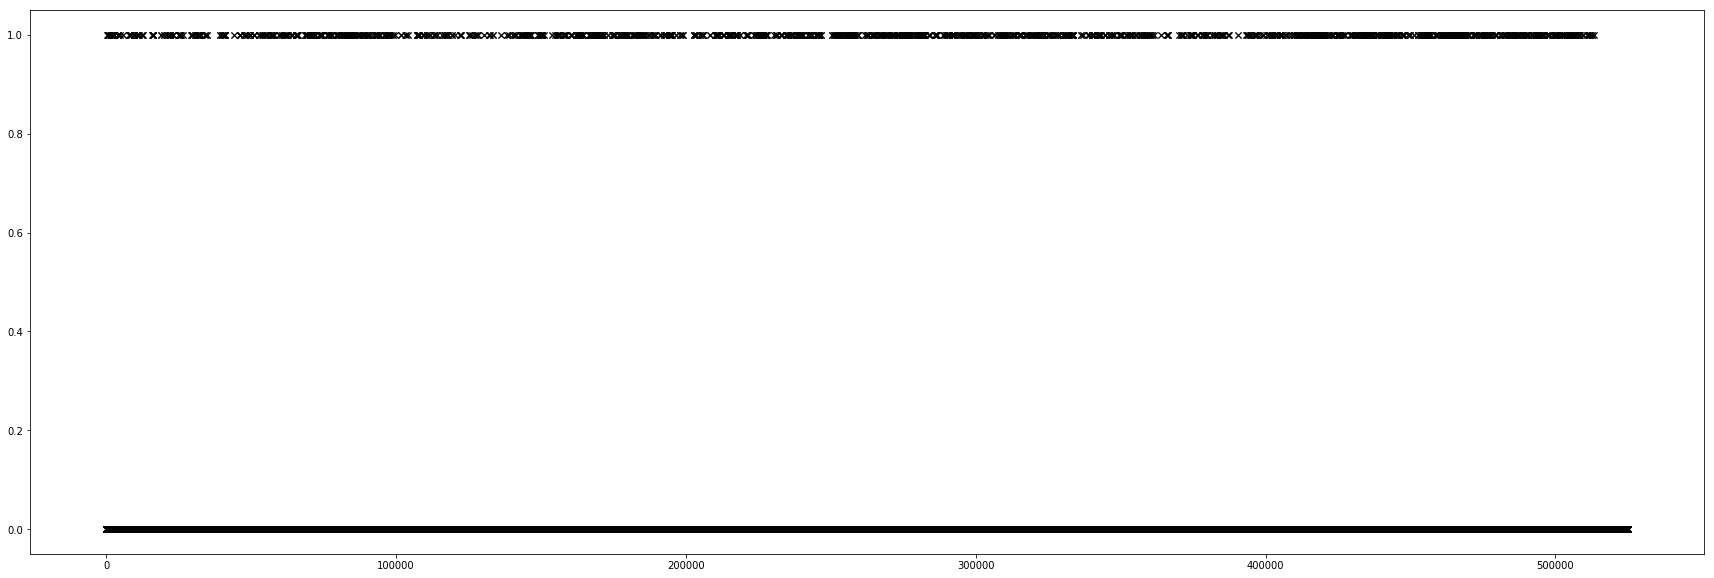

In [55]:
import math
ground_truth = txt_file_to_matrix(filename, "reference", 16000, "featureplan_new.txt", hop=10, win_len=25, feature_extractor="yaafe")
pp.plot(ground_truth, 'x', color='black');

In [ ]:
import math

def create_data_for_supervised(root_dir, hop, win_len, from_ep=0, to_ep=0, boost_for_imbalance=False, how_much_boost=6, balance=False,
                              overlapping=False,
                              fuzzy_label=False):
    
    ## If we have numpy array in the folder, we will create input and output array via this function. Its arguments:
    # root_dir: The folder which stores numpy array.
    # hop: Hop length (we need it for Librosa)
    # win_len: Window length (we need it for Librosa)
    # from_ep: Location of first file which will be loaded into array
    # to_ep: Location of last file which will be loaded into array
    # boost_for_imbalance: If it is true, the number of positive labels is
    # increased artificially by labeling as positive every frame in the
    # direct  neighborhood  of  the  manually  annotated  change  point
    # and this number will be determined by how_much_boost parameter
    # balance: if it is true, we will discard some frame which are at the 
    # middle of single speaker segment.
    
    
    all_audio_paths = glob.glob(os.path.join(root_dir, '*wav'))
    matrix_of_all_audio = []
    
    output_all_array = []
    num = 0
    
    for single_audio_path in all_audio_paths:
        num += 1
        if ((num >= from_ep) and (num < to_ep)):
            
            end_time_array_second = []

            filename = (single_audio_path.split("/")[-1]).split(".")[0]
            print (filename)

            try:
   
                matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/crepe_ami_storage/" + filename + ".npy")

                print (matrix_of_single_audio.shape)
                    
                array_of_single_audio = np.expand_dims(matrix_of_single_audio, axis=1)
                
                if (matrix_of_single_audio is not None):

                    matrix_of_all_audio.extend(array_of_single_audio)
                    print (single_audio_path + " is done.")

                    main_set = "./txt_ami_full/" + filename + "_full_time.txt"# FILENAME PATH for TXT

                    with open(main_set) as f:
                        content = f.readlines()

                    # you may also want to remove whitespace characters like `\n` at the end of each line


                    # need to open text file
                    # after that, point the end point of speaker
                    # add 1 to point of speaker, add 0 otherwise
                    # time is in second format at the txt file
                    content = [x.strip() for x in content] 

                    for single_line in content:

                        end_time_array_second.append(single_line)

                        # we use following method to get milisecond version
                        # float(win_len + ((offset+100) * hop)) 
                        # we need to inversion of that
                    # print (end_time_array_second)

                    output_array = np.zeros(matrix_of_single_audio.shape[0])

                    for end_time in end_time_array_second:
                        end_time_ms = float(end_time)*1000
                        
                        which_start_hop = (end_time_ms-win_len)/hop # now we know, milisecond version of change
                                                    # which is located after which_hop paramater
                                                    # add 2 and round to up
                        which_end_hop = end_time_ms/hop # round to up

                        start_location = math.ceil(which_start_hop + 1)
                        end_location = math.ceil(which_end_hop)

                        # print ("s:", start_location)
                        # print ("e:", end_location)
                        if (boost_for_imbalance==False):
                            output_array[start_location:end_location+1] = 1.0

                        else:
                            if (fuzzy_label==False):
                                output_array[start_location-how_much_boost:end_location+1+how_much_boost] = 1.0
                            else:
                                output_array[start_location:end_location+1] = 1.0
                                for ix_label in range(1, how_much_boost):
                                    output_array[start_location-ix_label] = 1.0 - (float(ix_label)/how_much_boost)
                                    output_array[end_location+1+ix_label] = 1.0 - (float(ix_label)/how_much_boost)
                    output_all_array.extend(output_array)
            except:
                print ("Pass this file...")
                pass
            # print (output_array)
            # print (output_array.mean())
            # ar = np.arange(matrix_of_single_audio.shape[1]) # just as an example array
            # pp.plot(ar, output_array, 'x')
            # pp.show()
    
    # if (overlapping):
        ### IMPLEMENT IT
            
    audio_array = np.asarray(matrix_of_all_audio)
    
    input_array = audio_array
    
    output_all_array = np.asarray(output_all_array)
    output_all_array = np.expand_dims(output_all_array, axis=1)
    
    if (balance == True):
            loc_zeros = np.where(output_all_array == 0)[0]
            list_cons = [list(group) for group in mit.consecutive_groups(loc_zeros)]
            for single_list_con in list_cons:
                if (len(single_list_con) > 80):
                    first_zero_loc = single_list_con[0]
                    last_zero_loc = single_list_con[-1]
                    output_all_array[first_zero_loc+20:last_zero_loc-20] = 2
            loc_twos = np.where(output_all_array == 2)[0]
            list_cons = [list(group) for group in mit.consecutive_groups(loc_twos)]
            output_all_array = output_all_array.squeeze(axis=1)
            # print (output_all_array.shape)
            input_array = input_array[output_all_array != 2, :]
            # [idx==0,:]
            output_all_array = output_all_array[output_all_array != 2]   
            output_all_array = np.expand_dims(output_all_array, axis=1)
            
    
    print("inputs shape: ", input_array.shape)

    print("outputs shape: ", output_all_array.shape)

    return (input_array, output_all_array)

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.models import Model
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects


frame_shape = (800, 1)

## Network Architecture
# https://keras.io/getting-started/sequential-model-guide/

input_frame = keras.Input(frame_shape, name='main_input')

conv1 = layers.Conv1D(800, 9, padding="same")(input_frame)
conv1 = layers.LeakyReLU()(conv1)
conv1_BN = layers.BatchNormalization()(conv1)
conv1_drop = layers.Dropout(0.5)(conv1_BN)

#conv2 = layers.Conv1D(800, 9, padding="same")(conv1_drop)
#conv2 = layers.LeakyReLU()(conv2)
#conv2_BN = layers.BatchNormalization()(conv2)
#conv2_drop = layers.Dropout(0.3)(conv2_BN)


bidirectional_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_initializer='random_normal',
                bias_initializer='zeros'))(conv1_drop)
bidirectional_1 = layers.LeakyReLU()(bidirectional_1)
bidirectional_1_BN = layers.BatchNormalization()(bidirectional_1)
bidirectional_1_drop = layers.Dropout(0.5)(bidirectional_1_BN)

bidirectional_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True,  kernel_initializer='random_normal',
                bias_initializer='zeros'))(bidirectional_1_drop)
bidirectional_2 = layers.LeakyReLU()(bidirectional_2)
bidirectional_2_BN = layers.BatchNormalization()(bidirectional_2)
bidirectional_2_drop = layers.Dropout(0.5)(bidirectional_2_BN)

bidirectional_3 = layers.Bidirectional(layers.LSTM(36, return_sequences=True,  kernel_initializer='random_normal',
                bias_initializer='zeros'))(bidirectional_2_drop)
bidirectional_3 = layers.LeakyReLU()(bidirectional_3)
bidirectional_3_BN = layers.BatchNormalization()(bidirectional_3)
bidirectional_3_drop = layers.Dropout(0.5)(bidirectional_3_BN)


tdistributed_1 = layers.TimeDistributed(layers.Dense(40, kernel_initializer='random_normal',
                bias_initializer='zeros'))(bidirectional_3_drop)
tdistributed_1 = layers.LeakyReLU()(tdistributed_1)
tdistributed_1_BN = layers.BatchNormalization()(tdistributed_1)
tdistributed_1_drop = layers.Dropout(0.5)(tdistributed_1_BN)

tdistributed_2 = layers.TimeDistributed(layers.Dense(10, kernel_initializer='random_normal',
                bias_initializer='zeros'))(tdistributed_1_drop)
tdistributed_2 = layers.LeakyReLU()(tdistributed_2)
tdistributed_2_BN = layers.BatchNormalization()(tdistributed_2)
tdistributed_2_drop = layers.Dropout(0.5)(tdistributed_2_BN)


tdistributed_3 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid', kernel_initializer='random_normal',
                bias_initializer='zeros'))(tdistributed_2_drop)


# WE DO NOT NEED IT FOR TRAINING. SO DISCARD.
## Source: https://stackoverflow.com/questions/37743574/hard-limiting-threshold-activation-function-in-tensorflow
def step_activation(x):
    threshold = 0.4
    cond = tf.less(x, tf.fill(value=threshold, dims=tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

# https://stackoverflow.com/questions/47034692/keras-set-output-of-intermediate-layer-to-0-or-1-based-on-threshold

step_activation = layers.Dense(1, activation=step_activation, name='threshold_activation')(tdistributed_3)



model = Model(input_frame, tdistributed_3)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.0001, decay=0.00001)

Nadam = keras.optimizers.Nadam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=0.00001, schedule_decay=0.0004)

model.compile(loss='binary_crossentropy', optimizer="Nadam")

In [ ]:
from keras.models import load_model
import time
import more_itertools as mit


how_many_step = 40
how_many_repeat = 25

ix_repeat = 0


while (ix_repeat < how_many_repeat):
    ix_repeat += 1
    
    print ("REPEAT:", ix_repeat)
    ix_step = 0
    from_epi = 2
    
    while (ix_step < how_many_step):
        ix_step += 1

        print ("STEP:", ix_step)
        
        #print("relax")
        #time.sleep(2.5) 
        try:
            input_array, output_array = create_data_for_supervised ("./amicorpus/*/audio/", 100, 100, from_epi, from_epi+3, True, 12, True, False, True)

            print (np.mean(output_array))

            max_len = 800 # how many frame will be taken
            step = 800 # step size.

            input_array_specified = []
            output_array_specified = []

            for i in range (0, input_array.shape[0]-max_len, step):
                single_input_specified = (input_array[i:i+max_len,:])
                single_output_specified = (output_array[i:i+max_len,:])

                input_array_specified.append(single_input_specified)
                output_array_specified.append(single_output_specified)

            output_array_specified = np.asarray(output_array_specified)
            input_array_specified = np.asarray(input_array_specified)
            print (output_array_specified.shape)
            print (input_array_specified.shape)

            try:
                model.fit(input_array_specified, output_array_specified,
                   epochs=5,
                   batch_size=8,
                   validation_split = 0.2,
                   shuffle=False)

            except ValueError :
                print ("Pass this epoch.")
                pass
            
            model.save_weights('bilstm_cnn_crepe.h5')    

            input_array = []
            output_array = []
        except IndexError:
            print ("Index Error. Pass this.")
            pass

        from_epi += 5
    model.save_weights("bilstm_cnn_crepe" + str(ix_repeat) + ".h5")    
